[epoch 1] loss = 0.18595509029337084, accuracy = 0.9456166666666667
[epoch 2] loss = 0.0629538316490637, accuracy = 0.9804166666666667
[epoch 3] loss = 0.04485829999987612, accuracy = 0.9859
[epoch 4] loss = 0.03412696144192108, accuracy = 0.9893833333333333
[epoch 5] loss = 0.02683196294266405, accuracy = 0.9918
[epoch 6] loss = 0.021116592264898034, accuracy = 0.99335
[epoch 7] loss = 0.01699386654886604, accuracy = 0.9945666666666667
[epoch 8] loss = 0.013664410387959281, accuracy = 0.9959333333333333
[epoch 9] loss = 0.011429022434204177, accuracy = 0.9968
[epoch 10] loss = 0.009883115467650673, accuracy = 0.9974

测试集准确率：0.9925


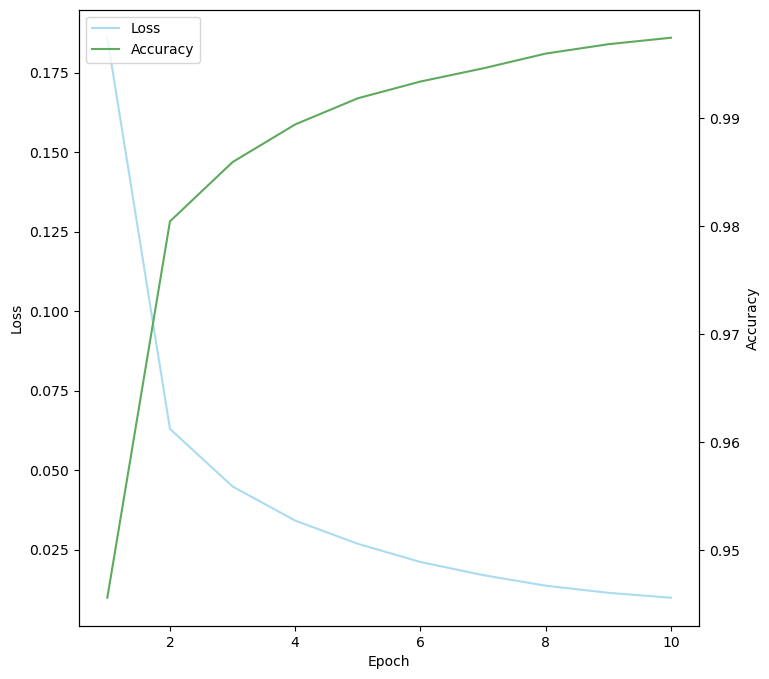

In [ ]:
import torch
import torch.optim
import torch.optim.lr_scheduler
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
NUM_EPOCHS = 10

class CNN(nn.Module):
    def __init__(self, in_channels, input_size, class_num):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16,
                               kernel_size=5, padding=2, stride=1, bias=False) # [16, 28, 28]
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.AvgPool2d(kernel_size=2) # [16, 14, 14]
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=5, padding=2, stride=1, bias=False) # [32, 14, 14]
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.AvgPool2d(kernel_size=2) # [32, 7, 7]
        self.fc = nn.Linear(input_size * input_size // 16 * 32, class_num)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.flatten(1)
        x = self.fc(x)
        return x

def load_and_preprocess_data(batch_size):
    # 数据加载与预处理

    # 将数据转化成张量类型，并进行标准化
    # MNIST数据集训练集的均值为0.1307，标准差为0.3081
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307), (0.3081))
    ])

    # 加载训练集和测试集
    train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_set = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    # 创建数据加载器
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    # shuffle=True -> 需要对数据进行随机重排
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train(num_epochs, train_loader, learning_rate, device):
    # 在训练集上训练模型

    model = CNN(1, 28, 10)
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim, T_max=num_epochs, eta_min=0.0)
    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        avg_loss = 0
        correct = 0
        num_samples = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images.to(device)
            labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optim.zero_grad()
            loss.backward()
            optim.step()
            if batch_idx + 1 == len(train_loader):
                scheduler.step()
            avg_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=False)
            correct += (pred == labels).sum().item()
            num_samples += images.shape[0]
        avg_loss /= len(train_loader)
        accuracy = correct / num_samples
        print(f'[epoch {epoch + 1}] loss = {avg_loss}, accuracy = {accuracy}')
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)

    return model, history

def test(model, test_loader, device):
    # 在测试集上评估模型的性能

    model.eval()
    correct = 0
    num_samples = 0
    with torch.no_grad():
        for (images, labels) in test_loader:
            images.to(device)
            labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1, keepdim=False)
            correct += (pred == labels).sum().item()
            num_samples += images.shape[0]
    accuracy = correct / num_samples
    print(f'\n测试集准确率：{accuracy}')

def main():
    train_loader, test_loader = load_and_preprocess_data(BATCH_SIZE)
    model, history = train(NUM_EPOCHS, train_loader, 1e-3, DEVICE)
    test(model, test_loader, DEVICE)

    plt.figure(figsize=(8, 8))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    line1 = plt.plot([i for i in range(1, NUM_EPOCHS + 1)], history['loss'], label='Loss', color='#AADCF0')[0]
    plt.twinx()
    plt.ylabel('Accuracy')
    line2 = plt.plot([i for i in range(1, NUM_EPOCHS + 1)], history['accuracy'], label='Accuracy', color='#5EAA5E')[0]
    lines = [line1, line2]
    labels = [line1.get_label(), line2.get_label()]
    plt.legend(lines, labels)
    plt.show()

if __name__ == '__main__':
    main()